<a href="https://colab.research.google.com/github/ChangjaeCHUNG/rl-study-w.-ns/blob/main/value%26policy_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import library & build environment

In [64]:
import gym, time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

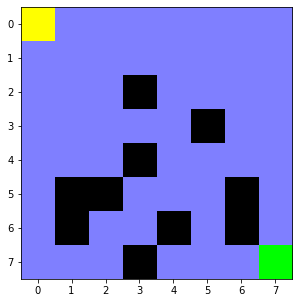

In [65]:
env = gym.make('FrozenLake8x8-v0')
# TRANSITION: 1/3의 확률로 의도한 방향, 1/3의 확률로 오른쪽, 1/3의 확률로 왼쪽

map = env.desc

def str_to_color(word):
    if word == b'S': return (255,255,0)
    if word == b'F': return (127,127,255)
    if word == b'H': return (0,0,0)
    if word == b'G': return (0,255,0)

colormap = np.array([[str_to_color(word) for word in line] for line in map])

plt.figure(figsize = (5,5))
plt.imshow(colormap)
plt.show()

# Initial Policy $\pi_0(\cdot|s)$

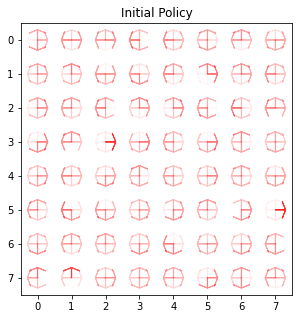

In [66]:
def plot_policy(policy):
    plt.figure(num=0, figsize = (5,5))
    plt.imshow(np.ones((8,8,3)))
    plt.title("Initial Policy")  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="r",alpha=policy[s][0],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="r",alpha=policy[s][1],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="r",alpha=policy[s][2],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="r",alpha=policy[s][3],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
    plt.show()

obs_space = env.observation_space
n_state = obs_space.n
act_space = env.action_space
n_act = act_space.n

policy = np.random.uniform(size=(n_state,n_act)) # 초기 policy를 random하게 초기화
policy = policy/np.sum(policy,axis=1,keepdims=True) # 각 state에서 policy 합이 1이 되도록 함

plot_policy(policy)

# Policy Evaluation

In this step, value function for **fixed policy** $\pi$ is computed. 
We will mainly use Bellman equation for $V_\pi$:

$V_\pi(s)=\displaystyle\sum_a\pi(a|s)\sum_{s'}[r(s,a,s')+\gamma V_\pi(s')]P(s'|s,a)$

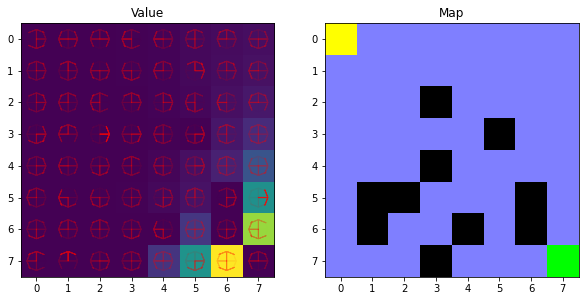

In [67]:
def policy_evaluation(env, policy, gamma = 0.99, epsilon = 1e-6):
    '''
    gamma : discount factor
    epsilon : 종료 조건
    '''
    
    # Extract environment information
    obs_space = env.observation_space
    n_state = obs_space.n
    P = env.unwrapped.P # transition model
    
    v = np.random.uniform(size=(n_state,1)) # Value를 random하게 초기화
    
    while True:
        v_prime = np.zeros((n_state,))
        for s in P.keys(): # For all states s, update v(s)
            for a in P[s].keys(): # For all actions a
                '''
                Bellman Equation
                '''
                for transition_prob, next_s, reward, _ in P[s][a]: # For all possible transitions (s,a,s')
                    v_prime[s] += (reward + gamma * v[next_s]) * transition_prob * policy[s][a] # Reward 자체가 State의 함수가 아니라 state, action, next state로 정의되어 있기 때문에 식의 형태가 약간 다름
        
        err = np.max(np.abs(v-v_prime)) # 각 지점에서 구한 v와 v_prime의 차이 중 최댓값
        v = v_prime
        if err < epsilon:
            break
    return v

def plot_result(policy, value):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    ax1.set_title("Value")
    ax1.imshow(np.reshape(value, (8,8)))
    ax2.set_title("Map")
    ax2.imshow(colormap)
    len_arrow = 0.2
    for i in range(8):
        for j in range(8):
            s = 8 * i + j
            if policy[s][0] > 0:
                ax1.arrow(j,i, -len_arrow, 0, color = "r", alpha = policy[s][0], width = 0.01, head_width = 0.5, head_length = 0.1, overhang = 1)
            if policy[s][1] > 0:
                ax1.arrow(j,i, 0, len_arrow, color = "r", alpha = policy[s][1], width = 0.01, head_width = 0.5, head_length = 0.1, overhang = 1)
            if policy[s][2] > 0:
                ax1.arrow(j,i, len_arrow, 0, color = "r", alpha = policy[s][2], width = 0.01, head_width = 0.5, head_length = 0.1, overhang = 1)
            if policy[s][3] > 0:
                ax1.arrow(j,i, 0, -len_arrow, color = "r", alpha = policy[s][3], width = 0.01, head_width = 0.5, head_length = 0.1, overhang = 1)


if __name__ == '__main__':
    value = policy_evaluation(env, policy, gamma = 0.99, epsilon = 1e-6)
    plot_result(policy, value)

# Policy Improvement by Q value

In this step, we update policy distribution using the value function computed by policy evaluation.
A new policy distribution is updated greedly as follows:

$Q_{\pi_i}(s,a)=\displaystyle\sum_{s'}[r(s,a,s')+\gamma V_{\pi_i}(s')]P(s'|s,a)$

$\pi_{i+1} = \displaystyle \arg\max_a Q_{\pi_i}(s,a)$

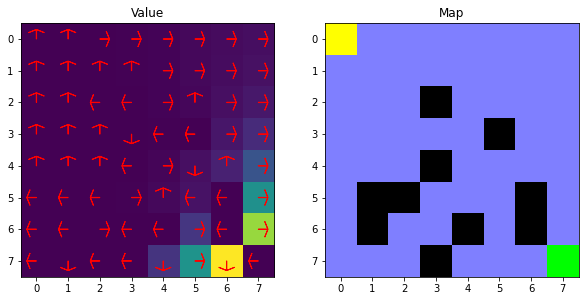

In [68]:
def policy_improvement(env, v, gamma = 0.99):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    P = env.unwrapped.P

    q = np.zeros((n_state,n_act)) # initialize Q value
    
    for s in P.keys(): # For all states s,
        for a in P[s].keys(): # For all actions a
            for transition_prob, next_s, reward, _ in P[s][a]:
                q[s,a] += (reward + gamma*v[next_s]) * transition_prob # Compute q[s,a] from v[s'], keep adding r[s,a,s']+gamma*v[s'] for all transition
                    
    policy = np.zeros((n_state,n_act))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1
    
    return policy

if __name__ == '__main__':
    policy = policy_improvement(env, value)
    plot_result(policy, value)

# Policy Iteration

Policy iteration algorithm consists of four steps:

(1) Initial policy distribution is randomly initialized

(2) Value function for current policy is computed by policy evaluation

(3) Policy distribution is greedily updated using value function from (2)

(4) If policy distribution doesn't change, then stop. Othrewise, repeat (1) ~ (3)

Computation Time : 17.61


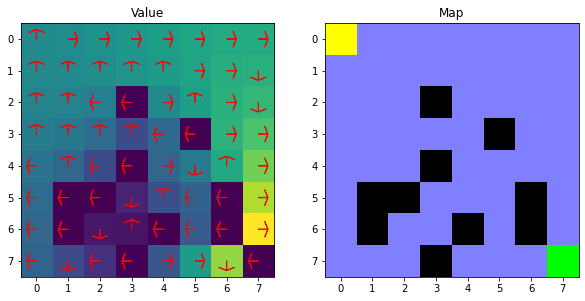

In [69]:
def policy_iteration(env):
    # (1)
    policy = np.random.uniform(size=(n_state,n_act))
    policy = policy/np.sum(policy,axis=1,keepdims=True)

    while True:
        value = policy_evaluation(env, policy) # (2)
        policy_prime = policy_improvement(env, value) # (3)

        # (4)
        if (policy == policy_prime).all(): 
            break # If policy doesn't change, stop
        policy = policy_prime # update new policy and repeat
    
    return policy, value
    
if __name__=='__main__': 
    start = time.time()
    policy, value = policy_iteration(env)
    print("Computation Time : %.2f"%(time.time() - start))
    plot_result(policy, value)

# Value Iteration

Optimal value function will be found using Bellman optimality equation

$V^*(s) = \displaystyle\max_aQ^*(s,a) = \max_a \sum_{s'}[r(s,a,s')+\gamma V^{*}(s')]P(s'|s,a)$

$\pi^*(s) = \displaystyle Q^*(s,a)$

Value iteration consists of three steps:

(1) Initial value is randomly initialized

(2) Update value function

(3) If infinite distance between updated value and current value is less than epsilon, then stop. Otherwise, repeat (2)

Computation Time : 0.63



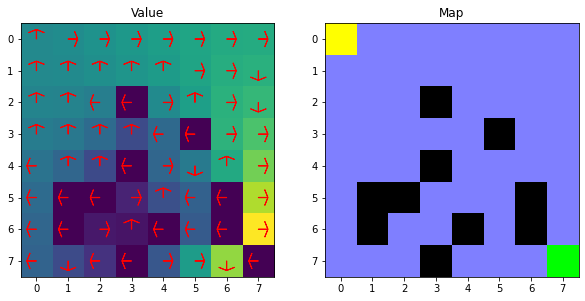

In [70]:
def value_iteration(env,gamma=0.99,epsilon=1e-6):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    P = env.unwrapped.P

    value = np.random.uniform(size=(n_state,1)) # Value를 random하게 초기화
    
    while True: 
        q = np.zeros((n_state,n_act)) # Compute Q value    
        for s in P.keys(): # For all states s
            for a in P[s].keys(): # For all actions a
                for prob, next_s, reward, done in P[s][a]: # For all possible transitions s'
                    q[s,a] += (reward + gamma*value[next_s])*prob
        v_prime = np.max(q,axis=1)

        err = np.max(np.abs(value-v_prime))
        value = v_prime
        if err < epsilon:
            break
            
    policy = np.zeros((n_state,n_act))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1 # Value가 최대인 방향을 향하도록 policy 설정
    
    return policy, value

if __name__=='__main__': 
    start = time.time()
    policy, value = value_iteration(env)
    print("Computation Time : %.2f"%(time.time() - start))
    print('')
    
    plot_result(policy, value)

# What if there's no noise?

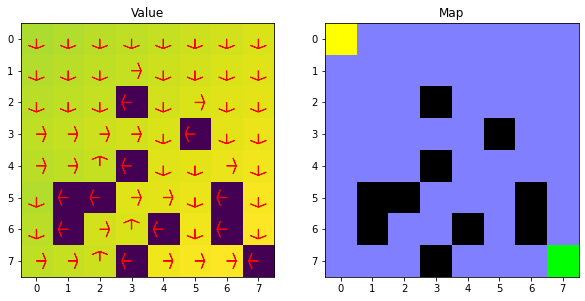

In [72]:
env = gym.make('FrozenLake8x8-v0', is_slippery = False)

policy, value = value_iteration(env) # gamma = 0.99
plot_result(policy, value)

# Additional topics

## Run optimal policy

In [ ]:
obs = env.reset()
for t in range(10000):
    print('t = %d'%t)
    env.render()
    print('')
    action = np.random.choice(n_act, 1, p=policy[obs][:])[0]
    next_obs, reward, done, info = env.step(action)
    obs = next_obs
    if done:
        break
env.render()
env.close()

## Faster code with Numpy

### Policy Iteration

Better implementation using numpy functions

This is computationally faster than above implementation

For loop is replaced with numpy native functions, such as 'np.tile' and 'np.sum'

Policy Iteration Compact
Computation Time : 0.82



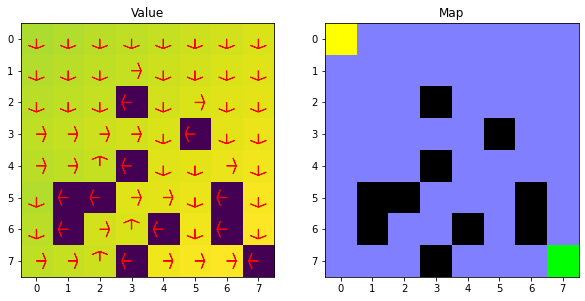

In [61]:
def policy_evaluation_np(env, P, r, policy, gamma = 0.99, epsilon = 1e-6):
    
    # Extract environment information
    obs_space = env.observation_space
    act_space = env.action_space
    n_state = obs_space.n
    n_act = act_space.n
        
    # Random initial
    v = np.random.uniform(size=(n_state,))
    
    while True:
        v_prime = np.sum(policy*np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2),axis=1)
        dist = np.max(np.abs(v-v_prime))
        v = v_prime
        if dist < epsilon:
            break
    return v

def policy_improvement_np(env, P, r, v, gamma = 0.99):
    obs_space = env.observation_space
    act_space = env.action_space
    n_state = obs_space.n
    n_act = act_space.n
    
    q = np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2)
                    
    policy = np.zeros((n_state,n_act))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1
    
    return policy

def policy_iteration_np(env):
    policy = np.random.uniform(size=(n_state,n_act))
    policy = policy/np.sum(policy,axis=1,keepdims=True)
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward
            
    while True:
        value = policy_evaluation_np(env, P, r, policy) # Evaluate value of current policy
        policy_prime = policy_improvement_np(env, P, r, value) # Find greedy policy

        if (policy == policy_prime).all(): # If policy doesn't change, stop
            break
        policy = policy_prime # update new policy
    
    return policy, value

if __name__=='__main__': 
    print("Policy Iteration Compact")
    start = time.time()
    policy, value = policy_iteration_np(env)
    print("Computation Time : %.2f"%(time.time() - start))
    print('')
    
    plot_result(policy, value)

### Value Iteration

Policy Iteration Compact
Computation Time : 0.11



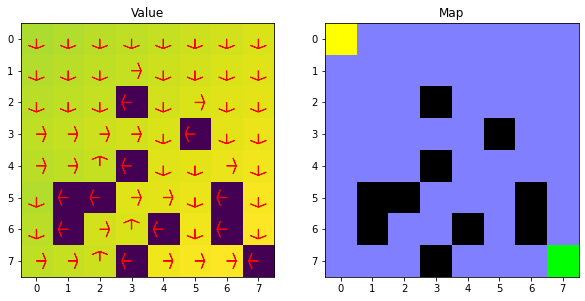

In [63]:
def value_iteration_np(env,gamma=0.99,epsilon=1e-6):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward

    value = np.random.uniform(size=(n_state,))
    
    while True: 
        q = np.sum((r+gamma*np.tile(value[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2)
        v_prime = np.max(q,axis=1)
        dist = np.max(np.abs(value-v_prime))
        value = v_prime
        if dist < epsilon:
            break

    policy = np.zeros((n_state,n_act))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1
    
    return policy, value

if __name__=='__main__': 
    print("Policy Iteration Compact")
    import time
    start = time.time()
    policy, value = value_iteration_np(env)
    print("Computation Time : %.2f"%(time.time() - start))
    print('')
    
    plot_result(policy, value)